In [1]:
import os, h5py
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.layers.experimental import preprocessing

from track import SOLAR_LOGG, SOLAR_TEFF, SOLAR_ZX

print('tensorflow ==', tf.__version__)

%matplotlib inline

tensorflow == 2.3.2


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [28]:
name = 'test_model_1'

In [3]:
path = 'data/yrec_grid.h5'
h5f = h5py.File(path, 'r')

dset = h5f['data']
data = np.array(dset)
columns = dset.attrs['columns']

h5f.close()

In [4]:
df = pd.DataFrame(data, columns=columns)
del data

In [5]:
df.head()

,EEP,M/Msun,Age(Gyr),[Fe/H],fk,Rocrit,alphaMLT,Prot(days),log(Teff)(K),log(R/Rsun),log(Z/X)(surface)
0,1.000000,1.06,0.036089,0.1,6.0,2.75,1.5,0.374777,3.752937,-0.005539,-1.692670
1,1.045365,1.06,0.037402,0.1,6.0,2.75,1.5,0.383608,3.751863,-0.009092,-1.692682
2,1.067487,1.06,0.039110,0.1,6.0,2.75,1.5,0.395994,3.751114,-0.010804,-1.692698
3,1.069806,1.06,0.041330,0.1,6.0,2.75,1.5,0.412794,3.750794,-0.010895,-1.692721
4,1.079711,1.06,0.044216,0.1,6.0,2.75,1.5,0.435389,3.750821,-0.010110,-1.692753


In [6]:
mask = df['Prot(days)'] == 0
df.drop(df.loc[mask].index, inplace=True)

In [7]:
# df['log(R/Rsun)'] = np.log10(df['R/Rsun'])
df['log(g)'] = SOLAR_LOGG + np.log10(df['M/Msun']) - 2 * df['log(R/Rsun)']
df['log(L/Lsun)'] = 2 * df['log(R/Rsun)'] + 4 * (df['log(Teff)(K)'] - np.log10(SOLAR_TEFF))
df['[Fe/H](surface)'] = df['log(Z/X)(surface)'] - np.log10(SOLAR_ZX)

In [8]:
df['log(Prot)(days)'] = np.log10(df['Prot(days)'])

In [9]:
df['log(Age)(Gyr)'] = np.log10(df['Age(Gyr)'])

In [10]:
# non_diff = df.loc[df['EEP'] == 1, '[Fe/H](surface)'].to_numpy() == df.loc[df['EEP'] == 2, '[Fe/H](surface)'].to_numpy()
# np.sum(non_diff)

In [11]:
# start = df.loc[df['EEP'] == 1, '[Fe/H](surface)'].index.to_numpy()
# stop = df.loc[df['EEP'] == 3, '[Fe/H](surface)'].index.to_numpy()

In [12]:
# non_diff_idx = np.concatenate([np.arange(st, sp+1, dtype=int) for st, sp in zip(start[non_diff], stop[non_diff])])

In [13]:
# len(non_diff_idx) / len(df)

In [14]:
# len(df) - len(non_diff_idx)

In [15]:
# df.drop(non_diff_idx, inplace=True)

In [16]:
# len(df)

In [17]:
random_state = 2

train = df.sample(frac=0.8, random_state=random_state)
test = df.drop(train.index)

In [18]:
print('Train length = ', len(train))
print('Test length = ', len(test))

Train length =  38447873
Test length =  9611968


In [19]:
del df

In [20]:
input_cols = ['EEP', 'M/Msun', '[Fe/H]', 'alphaMLT', 'fk', 'Rocrit']
output_cols = ['log(Age)(Gyr)', 'log(Teff)(K)', 'log(R/Rsun)', '[Fe/H](surface)', 'log(Prot)(days)']

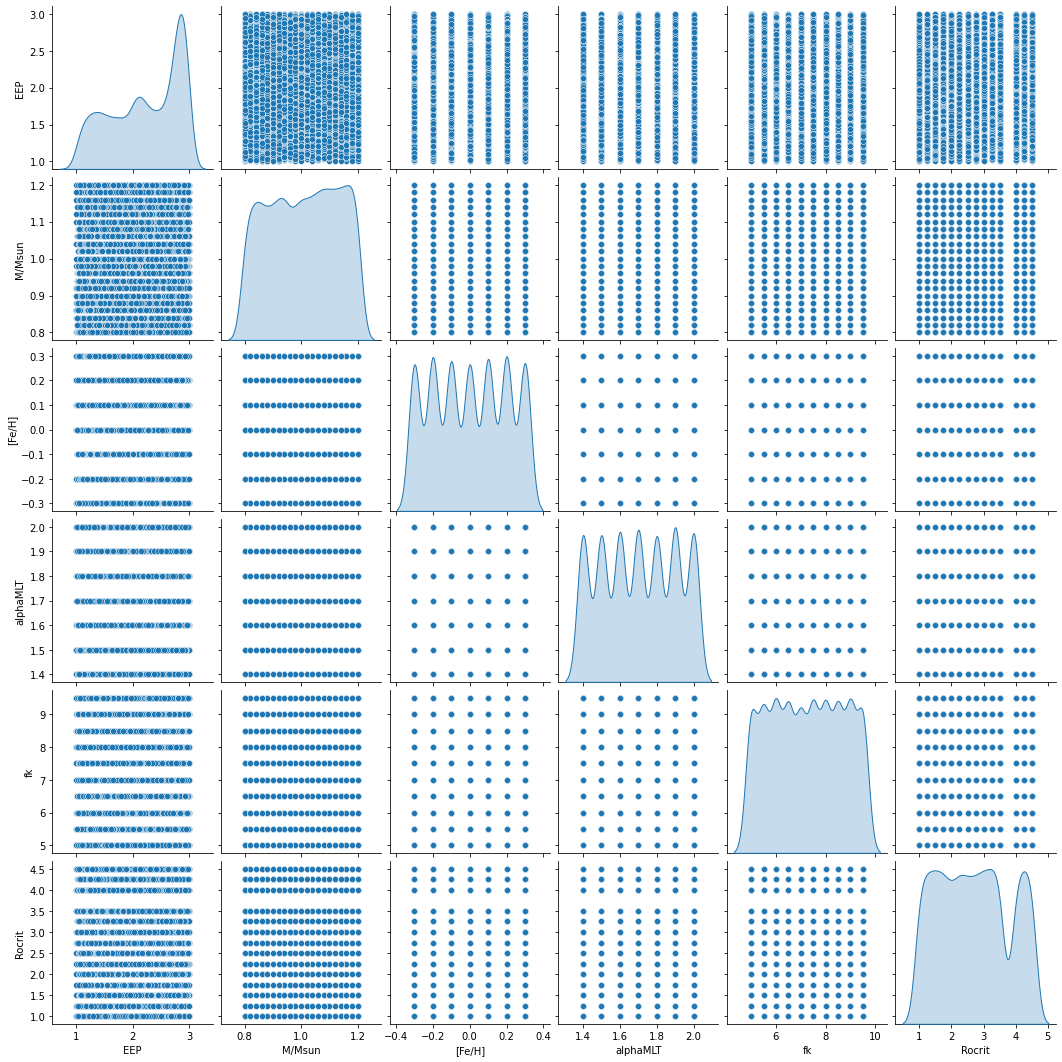

In [21]:
sns.pairplot(train[input_cols].sample(10000), diag_kind='kde');

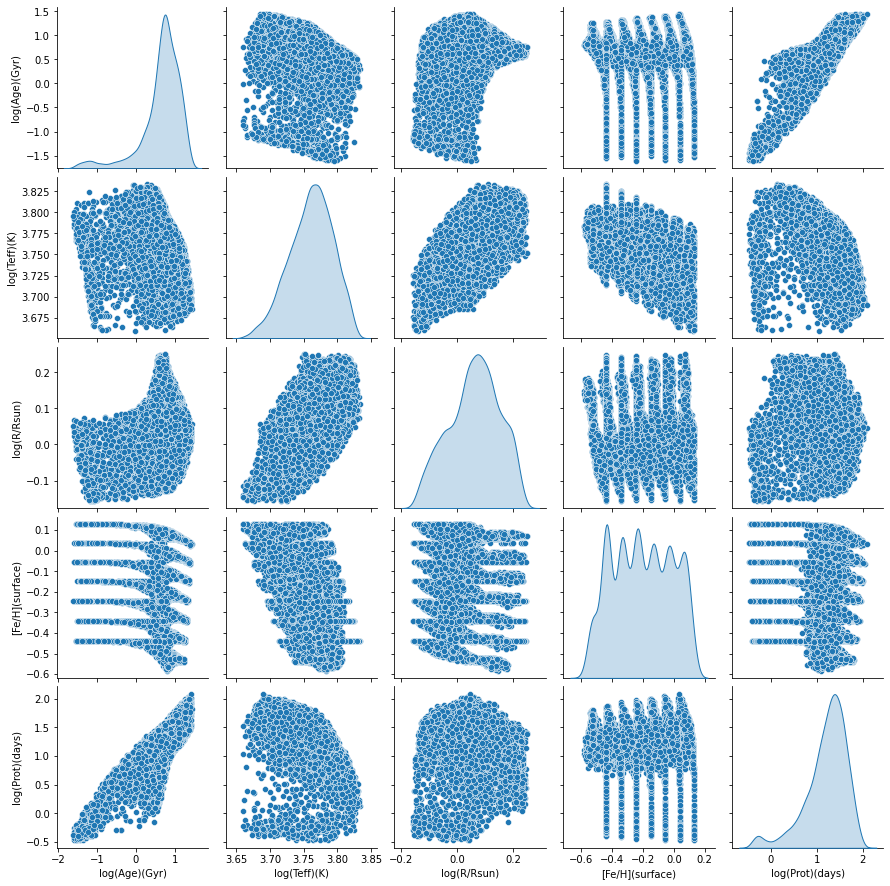

In [22]:
sns.pairplot(train[output_cols].sample(10000), diag_kind='kde');

In [23]:
input_normalizer = preprocessing.Normalization()
input_normalizer.adapt(train[input_cols].to_numpy())

In [24]:
input_mean = input_normalizer.mean.numpy()
input_var = input_normalizer.variance.numpy()
for col, mean, var in zip(input_cols, input_mean, input_var):
    print(f'{col:<15}: {mean:.3e}, {var:.3e}')

EEP            : 2.220e+00, 3.686e-01
M/Msun         : 1.008e+00, 1.474e-02
[Fe/H]         : -2.550e-03, 3.995e-02
alphaMLT       : 1.700e+00, 4.003e-02
fk             : 7.250e+00, 2.062e+00
Rocrit         : 2.679e+00, 1.173e+00


In [25]:
output_normalizer = preprocessing.Normalization()
output_normalizer.adapt(train[output_cols].to_numpy())

In [26]:
output_mean = output_normalizer.mean.numpy()
output_var = output_normalizer.variance.numpy()
for col, mean, var in zip(output_cols, output_mean, output_var):
    print(f'{col:<15}: {mean:.3e}, {var:.3e}')

log(Age)(Gyr)  : 6.385e-01, 2.842e-01
log(Teff)(K)   : 3.761e+00, 1.023e-03
log(R/Rsun)    : 6.035e-02, 8.026e-03
[Fe/H](surface): -2.013e-01, 3.560e-02
log(Prot)(days): 1.195e+00, 2.106e-01


In [27]:
output_rescaler = preprocessing.Rescaling(scale=np.sqrt(output_var), 
                                          offset=output_mean)

In [29]:
def build_model(n_neurons, n_hidden, activation='elu', l2_reg=0.0):
    reg = regularizers.L2(l2_reg)
    hidden_layers = [layers.Dense(n_neurons, 
                                  activation=activation, 
                                  kernel_regularizer=reg) for layer in range(n_hidden)]
    all_layers = [input_normalizer] + hidden_layers + [layers.Dense(len(output_cols)), output_rescaler]
    model = keras.Sequential(all_layers)
    return model

In [30]:
model = build_model(128, 6, l2_reg=0.0)

In [31]:
model.save(f'data/models/{name}')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: data/models/test_model_1/assets


In [32]:
learning_rate = 1e-4
momentum = 0.999

model.compile(loss='mean_squared_error',
#              optimizer=keras.optimizers.SGD(learning_rate, momentum=momentum),
             optimizer=keras.optimizers.Adam(learning_rate)
             )

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 6)                 13        
_________________________________________________________________
dense (Dense)                (None, 128)               896       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               1

In [34]:
batch_size = 8192*2

print('Number of batches:', len(train)//batch_size)
print('Remainder:', len(train)%batch_size)

Number of batches: 2346
Remainder: 11009


In [117]:
%%time
history = model.fit(
    train[input_cols], train[output_cols],
    validation_split=0.2,
    batch_size=batch_size,
    verbose=0, epochs=100,
)

CPU times: user 34min 27s, sys: 3min 14s, total: 37min 41s
Wall time: 13min 13s


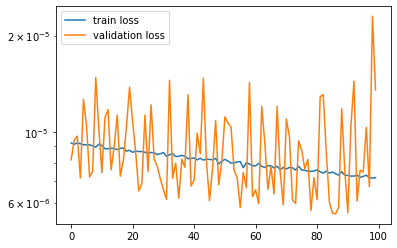

In [118]:
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train loss')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='validation loss')

plt.yscale('log')
plt.legend()

In [79]:
model.save(f'data/models/{name}')

INFO:tensorflow:Assets written to: data/models/test_model_1/assets


In [80]:
pred = pd.DataFrame(model.predict(test[input_cols], batch_size=batch_size), columns=output_cols)
pred.head()

,log(Age)(Gyr),log(Teff)(K),log(R/Rsun),[Fe/H](surface),log(Prot)(days)
0,-1.440279,3.752429,-0.006743,-0.057715,-0.434386
1,-0.998042,3.752204,-0.004894,-0.055960,0.089083
2,-0.927115,3.752367,-0.004554,-0.055946,0.223517
3,-0.267103,3.754057,0.002824,-0.059724,0.808275
4,-0.117076,3.754387,0.005851,-0.061636,0.893635


In [81]:
truth = test[output_cols].reset_index(drop=True)
error = truth - pred
frac_error = (truth - pred) / truth

In [82]:
truth.head()

,log(Age)(Gyr),log(Teff)(K),log(R/Rsun),[Fe/H](surface),log(Prot)(days)
0,-1.442631,3.752937,-0.005539,-0.054398,-0.426228
1,-1.035855,3.752855,-0.005913,-0.055013,0.025122
2,-0.957876,3.753089,-0.005414,-0.055218,0.175681
3,-0.277206,3.754258,0.001065,-0.060013,0.800040
4,-0.121034,3.754744,0.004095,-0.062651,0.890828


In [83]:
log_cols = ['log(Age)(Gyr)', 'log(Teff)(K)', 'log(R/Rsun)', 'log(Prot)(days)']

for col in log_cols:
    error[f'10^{col}'] = 10**truth[col] - 10**pred[col]
    frac_error[f'10^{col}'] = (10**truth[col] - 10**pred[col]) / 10**truth[col]

In [84]:
error.head()

,log(Age)(Gyr),log(Teff)(K),log(R/Rsun),[Fe/H](surface),log(Prot)(days),10^log(Age)(Gyr),10^log(Teff)(K),10^log(R/Rsun),10^log(Prot)(days)
0,-0.002351,0.000507,0.001204,0.003317,0.008158,-0.000196,6.611190,0.002734,0.006974
1,-0.037813,0.000651,-0.001019,0.000948,-0.063962,-0.008376,8.473248,-0.002318,-0.168124
2,-0.030760,0.000723,-0.000861,0.000728,-0.047836,-0.008087,9.416303,-0.001959,-0.174499
3,-0.010104,0.000201,-0.001759,-0.000289,-0.008235,-0.012432,2.630932,-0.004067,-0.120792
4,-0.003957,0.000358,-0.001757,-0.001015,-0.002807,-0.006928,4.678767,-0.004091,-0.050430


In [85]:
error.mean()

log(Age)(Gyr)        -0.002741
log(Teff)(K)          0.000005
log(R/Rsun)          -0.000070
[Fe/H](surface)       0.000105
log(Prot)(days)      -0.001771
10^log(Age)(Gyr)     -0.035512
10^log(Teff)(K)       0.069819
10^log(R/Rsun)       -0.000120
10^log(Prot)(days)   -0.047892
dtype: float64

In [86]:
error.std()

log(Age)(Gyr)         0.004985
log(Teff)(K)          0.000618
log(R/Rsun)           0.000917
[Fe/H](surface)       0.001173
log(Prot)(days)       0.005491
10^log(Age)(Gyr)      0.040915
10^log(Teff)(K)       8.302029
10^log(R/Rsun)        0.002593
10^log(Prot)(days)    0.137581
dtype: float64

In [87]:
frac_error.mean()

log(Age)(Gyr)         0.019118
log(Teff)(K)          0.000001
log(R/Rsun)           0.001187
[Fe/H](surface)      -0.007730
log(Prot)(days)      -0.002368
10^log(Age)(Gyr)     -0.006398
10^log(Teff)(K)       0.000009
10^log(R/Rsun)       -0.000163
10^log(Prot)(days)   -0.004168
dtype: float64

In [88]:
frac_error.std()

log(Age)(Gyr)         8.647156
log(Teff)(K)          0.000164
log(R/Rsun)           3.600534
[Fe/H](surface)       4.171415
log(Prot)(days)       3.545153
10^log(Age)(Gyr)      0.011778
10^log(Teff)(K)       0.001424
10^log(R/Rsun)        0.002111
10^log(Prot)(days)    0.013117
dtype: float64

In [89]:
from scipy import stats

In [92]:
pd.Series(stats.median_abs_deviation(error), error.columns)

log(Age)(Gyr)         0.001277
log(Teff)(K)          0.000358
log(R/Rsun)           0.000527
[Fe/H](surface)       0.000697
log(Prot)(days)       0.001664
10^log(Age)(Gyr)      0.024872
10^log(Teff)(K)       4.738073
10^log(R/Rsun)        0.001371
10^log(Prot)(days)    0.064527
dtype: float64

In [93]:
pd.Series(stats.median_abs_deviation(frac_error), frac_error.columns)

log(Age)(Gyr)         0.001605
log(Teff)(K)          0.000095
log(R/Rsun)           0.006659
[Fe/H](surface)       0.003657
log(Prot)(days)       0.001363
10^log(Age)(Gyr)      0.002955
10^log(Teff)(K)       0.000825
10^log(R/Rsun)        0.001214
10^log(Prot)(days)    0.003840
dtype: float64

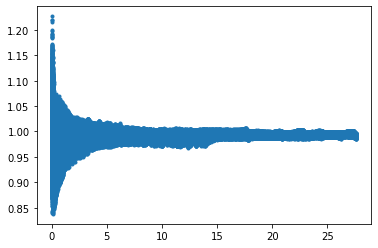

In [111]:
plt.plot(10**truth['log(Age)(Gyr)'], 10**error['log(Age)(Gyr)'], '.');

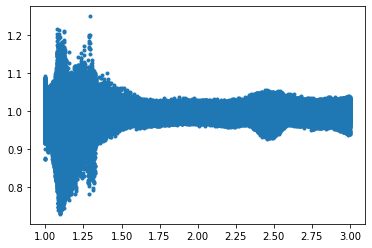

In [102]:
plt.plot(test['EEP'], 10**error['log(Prot)(days)'], '.');

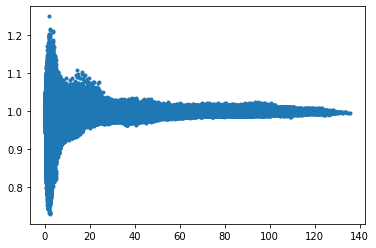

In [114]:
plt.plot(10**truth['log(Prot)(days)'], 10**error['log(Prot)(days)'], '.');

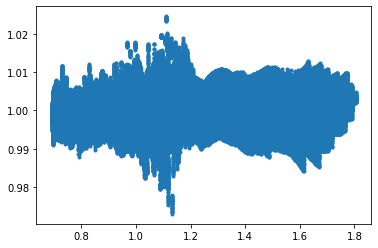

In [115]:
plt.plot(10**truth['log(R/Rsun)'], 10**error['log(R/Rsun)'], '.');

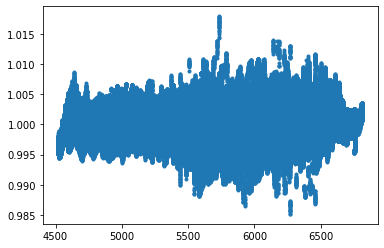

In [116]:
plt.plot(10**truth['log(Teff)(K)'], 10**error['log(Teff)(K)'], '.');

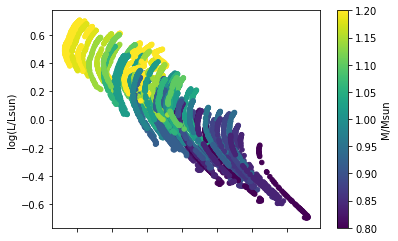

In [110]:
ax = test.iloc[:5000].plot(x='log(Teff)(K)', y='log(L/Lsun)', c='M/Msun', cmap='viridis', kind='scatter')

ax.invert_xaxis();